In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load Data

In [13]:
file_path="rideshare_kaggle.csv"
cab_rides_data=pd.read_csv(file_path)

In [14]:
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [15]:
cab_rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

## Basic Data Checks

In [20]:
missing_values = cab_rides_data.isnull().sum()

In [22]:
missing_values

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
v

In [24]:
missing_values_per_cab_type=cab_rides_data.groupby('cab_type')['price'].apply(lambda x:x.isnull().sum())

In [26]:
missing_values_per_cab_type

cab_type
Lyft        0
Uber    55095
Name: price, dtype: int64

In [28]:
# Convert `timestamp` to datetime format if not already done
cab_rides_data['timestamp'] = pd.to_datetime(cab_rides_data['timestamp'], unit='ms')

# Extract hour from `timestamp`
cab_rides_data['hour'] = cab_rides_data['timestamp'].dt.hour

# Create 2-hour time slots
cab_rides_data['time_slot'] = (cab_rides_data['hour'] // 2) * 2  # e.g., 0–1 becomes 0, 2–3 becomes 2

# Calculate the mean price for each time slot
slot_mean_price = cab_rides_data.groupby('time_slot')['price'].mean()

# Impute missing prices with the mean price of their respective time slot
cab_rides_data['price'] = cab_rides_data.apply(
    lambda row: slot_mean_price[row['time_slot']] if pd.isnull(row['price']) else row['price'],
    axis=1
)

# Verify if there are still missing values
missing_after_imputation = cab_rides_data['price'].isnull().sum()

print(f"Missing values in `price` after imputation: {missing_after_imputation}")


Missing values in `price` after imputation: 0


In [29]:
missing_values_per_cab_type=cab_rides_data.groupby('cab_type')['price'].apply(lambda x:x.isnull().sum())
missing_values_per_cab_type

cab_type
Lyft    0
Uber    0
Name: price, dtype: int64

In [30]:
cab_rides_data['is_rain'] = cab_rides_data['short_summary'].str.contains('rain', case=False).astype(int)

In [31]:
cab_rides_data['datetime'] = pd.to_datetime(cab_rides_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [32]:
cab_rides_data['date'] = cab_rides_data['datetime'].dt.date
cab_rides_data['time'] = cab_rides_data['datetime'].dt.time
cab_rides_data

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1970-01-18 21:09:12.607890,21,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,43.68,1544968800,33.73,1545012000,38.07,1544958000,20,0,2018-12-16,09:30:07
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1970-01-18 20:41:24.023677,20,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,47.30,1543251600,36.20,1543291200,43.92,1543251600,20,1,2018-11-27,02:00:23
2,981a3613-77af-4620-a42a-0c0866077d1e,1970-01-18 20:42:46.822198,20,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,47.55,1543320000,31.04,1543377600,44.12,1543320000,20,0,2018-11-28,01:00:22
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1970-01-18 20:45:53.582749,20,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,45.03,1543510800,30.30,1543550400,38.53,1543510800,20,0,2018-11-30,04:53:02
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1970-01-18 20:44:23.360223,20,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,42.18,1543420800,29.11,1543392000,35.75,1543420800,20,0,2018-11-29,03:49:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693066,616d3611-1820-450a-9845-a9ff304a4842,1970-01-18 20:48:28.386000,20,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,44.76,1543690800,27.77,1543658400,44.09,1543690800,20,0,2018-12-01,23:53:05
693067,633a3fc3-1f86-4b9e-9d48-2b7132112341,1970-01-18 20:48:28.386000,20,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,44.76,1543690800,27.77,1543658400,44.09,1543690800,20,0,2018-12-01,23:53:05
693068,64d451d0-639f-47a4-9b7c-6fd92fbd264f,1970-01-18 20:48:28.386000,20,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,44.76,1543690800,27.77,1543658400,44.09,1543690800,20,0,2018-12-01,23:53:05
693069,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,1970-01-18 20:48:28.386000,20,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,44.76,1543690800,27.77,1543658400,44.09,1543690800,20,0,2018-12-01,23:53:05


In [35]:
# Create "odd_time" column
cab_rides_data['odd_time'] = cab_rides_data['time'].apply(lambda x: 1 if x.hour < 6 else 0)

# Create "peak_time" column
cab_rides_data['peak_time'] = cab_rides_data['time'].apply(lambda x: 1 if (x.hour >= 8 and x.hour <= 10) or (x.hour >= 16 and x.hour <= 19) else 0)

# Print the updated dataframe
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,odd_time,peak_time
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1970-01-18 21:09:12.607890,21,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,33.73,1545012000,38.07,1544958000,20,0,2018-12-16,09:30:07,0,1
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1970-01-18 20:41:24.023677,20,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,36.20,1543291200,43.92,1543251600,20,1,2018-11-27,02:00:23,1,0
2,981a3613-77af-4620-a42a-0c0866077d1e,1970-01-18 20:42:46.822198,20,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,31.04,1543377600,44.12,1543320000,20,0,2018-11-28,01:00:22,1,0
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1970-01-18 20:45:53.582749,20,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,30.30,1543550400,38.53,1543510800,20,0,2018-11-30,04:53:02,1,0
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1970-01-18 20:44:23.360223,20,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,29.11,1543392000,35.75,1543420800,20,0,2018-11-29,03:49:20,1,0


In [38]:
#sorting by datetime column
cab_rides_data = cab_rides_data.sort_values(by='datetime')

In [41]:
cab_rides_data['day_of_week'] = cab_rides_data['datetime'].dt.day_name()

In [44]:
# Create "is_weekend" column
cab_rides_data['is_weekend'] = cab_rides_data['day_of_week'].apply(lambda x: 1 if x=="Saturday" or x=="Sunday" else 0)
cab_rides_data

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,odd_time,peak_time,day_of_week,is_weekend
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,e299c3bf-a429-4b19-af4a-ebd8e9ad74f7,1970-01-18 21:12:40.510,21,18,12,2018-12-18 19:15:10,America/New_York,Financial District,Haymarket Square,Uber,...,31.84,1545109200,20,0,2018-12-18,19:15:10,0,1,Tuesday,0
215397,20caa061-2ded-49f8-882b-1e7eae6285ff,1970-01-18 21:12:40.511,21,18,12,2018-12-18 19:15:10,America/New_York,Fenway,Theatre District,Uber,...,31.84,1545109200,20,0,2018-12-18,19:15:10,0,1,Tuesday,0
166550,7f1cbf41-2136-4e37-889d-dd0dfff02d38,1970-01-18 21:12:40.511,21,18,12,2018-12-18 19:15:10,America/New_York,Haymarket Square,Back Bay,Uber,...,31.84,1545109200,20,0,2018-12-18,19:15:10,0,1,Tuesday,0
290785,8c28dc35-c4a8-41e8-abe8-d5d65849448d,1970-01-18 21:12:40.510,21,18,12,2018-12-18 19:15:10,America/New_York,Northeastern University,Beacon Hill,Lyft,...,31.84,1545109200,20,0,2018-12-18,19:15:10,0,1,Tuesday,0


In [45]:
# Rename column 'cab_type' to 'cab_company', 'name' to 'cab_type', 'odd_time' to 'odd_time_of_travel' of cab_rides_data
cab_rides_data.rename(columns={
    'cab_type': 'cab_company',
    'odd_time': 'odd_time_of_travel'
}, inplace=True)

cab_rides_data.rename(columns={
    'name': 'cab_type'
}, inplace=True)


cab_rides_data.head()


,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,odd_time_of_travel,peak_time,day_of_week,is_weekend
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0


In [48]:
# Add a column which stores was the ride taken in day or night
cab_rides_data['is_night'] = cab_rides_data.apply(
    lambda row: not (row['sunriseTime'] <= row['datetime'].timestamp() <= row['sunsetTime']),
    axis=1
)

# Print the updated DataFrame
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,apparentTemperatureMaxTime,time_slot,is_rain,date,time,odd_time_of_travel,peak_time,day_of_week,is_weekend,is_night
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0,True
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0,True
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0,True
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0,True
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543186800,20,0,2018-11-26,03:40:46,1,0,Monday,0,True


In [49]:
# Remove the invalid `pd.set_option` line as 'future.no_silent_downcasting' is not a valid option.

# Convert 0 to False and 1 to True in the specified columns
columns_to_convert = ['peak_time', 'is_weekend', 'odd_time_of_travel', 'is_rain']

cab_rides_data[columns_to_convert] = cab_rides_data[columns_to_convert].apply(
    lambda col: col.replace({0: False, 1: True}).astype(bool)
)

cab_rides_data.head()

/var/folders/z1/fbf3jw4x2k17yv3z5f3l04jm0000gn/T/ipykernel_22837/1042968591.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda col: col.replace({0: False, 1: True}).astype(bool)
/var/folders/z1/fbf3jw4x2k17yv3z5f3l04jm0000gn/T/ipykernel_22837/1042968591.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda col: col.replace({0: False, 1: True}).astype(bool)
/var/folders/z1/fbf3jw4x2k17yv3z5f3l04jm0000gn/T/ipykernel_22837/1042968591.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,apparentTemperatureMaxTime,time_slot,is_rain,date,time,odd_time_of_travel,peak_time,day_of_week,is_weekend,is_night
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,1543186800,20,False,2018-11-26,03:40:46,True,False,Monday,False,True
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1970-01-18 20:40:03.646,20,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,1543186800,20,False,2018-11-26,03:40:46,True,False,Monday,False,True
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543186800,20,False,2018-11-26,03:40:46,True,False,Monday,False,True
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,1543186800,20,False,2018-11-26,03:40:46,True,False,Monday,False,True
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1970-01-18 20:40:03.647,20,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543186800,20,False,2018-11-26,03:40:46,True,False,Monday,False,True


In [50]:
# Cleanup before selecting data
cab_rides_data['year'] = cab_rides_data['datetime'].dt.year
cab_rides_data['month'] = cab_rides_data['datetime'].dt.month
cab_rides_data['day'] = cab_rides_data['datetime'].dt.day
cab_rides_data['hour'] = cab_rides_data['datetime'].dt.hour
cab_rides_data['minute'] = cab_rides_data['datetime'].dt.minute
cab_rides_data['weekday'] = cab_rides_data['datetime'].dt.weekday

# Ensure boolean columns are explicitly cast to boolean type
cab_rides_data['is_night'] = cab_rides_data['is_night'].astype(bool)
cab_rides_data['is_rain'] = cab_rides_data['is_rain'].astype(bool)
cab_rides_data['is_weekend'] = cab_rides_data['is_weekend'].astype(bool)

print(cab_rides_data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 693071 entries, 66422 to 166551
Data columns (total 69 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           693071 non-null  object        
 1   timestamp                    693071 non-null  datetime64[ns]
 2   hour                         693071 non-null  int32         
 3   day                          693071 non-null  int32         
 4   month                        693071 non-null  int32         
 5   datetime                     693071 non-null  datetime64[ns]
 6   timezone                     693071 non-null  object        
 7   source                       693071 non-null  object        
 8   destination                  693071 non-null  object        
 9   cab_company                  693071 non-null  object        
 10  product_id                   693071 non-null  object        
 11  cab_type                   

In [51]:
# columns_to_include = [
#     'source', 'destination', 'cab_company', 'cab_type', 'price', 'distance',
#     'surge_multiplier', 'apparentTemperature', 'precipIntensity',
#     'day_of_week'
# ]

# columns_to_include = [
#     'source', 'destination', 'cab_company', 'cab_type', 'price', 'distance',
#     'surge_multiplier', 'apparentTemperature', 'short_summary', 'precipIntensity',
#     'precipProbability', 'uvIndex', 'visibility.1', 'is_night', 'precipIntensityMax',
#     'is_rain', 'odd_time_of_travel', 'peak_time', 'day_of_week', 'is_weekend'
# ]

columns_to_include = [
    'source', 'destination', 'cab_company', 'cab_type', 'price', 'distance',
    'surge_multiplier', 'apparentTemperature', 'precipIntensity',
    'visibility.1', 'precipIntensityMax', 'day', 'month', 'hour', 'minute',
]

selected_features = cab_rides_data[columns_to_include]
print(selected_features.info())


<class 'pandas.core.frame.DataFrame'>
Index: 693071 entries, 66422 to 166551
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   source               693071 non-null  object 
 1   destination          693071 non-null  object 
 2   cab_company          693071 non-null  object 
 3   cab_type             693071 non-null  object 
 4   price                693071 non-null  float64
 5   distance             693071 non-null  float64
 6   surge_multiplier     693071 non-null  float64
 7   apparentTemperature  693071 non-null  float64
 8   precipIntensity      693071 non-null  float64
 9   visibility.1         693071 non-null  float64
 10  precipIntensityMax   693071 non-null  float64
 11  day                  693071 non-null  int32  
 12  month                693071 non-null  int32  
 13  hour                 693071 non-null  int32  
 14  minute               693071 non-null  int32  
dtypes: float64(7), int

## Visualization Pending

In [53]:
cab_rides_data_for_visualisation =cab_rides_data.copy(deep=True)

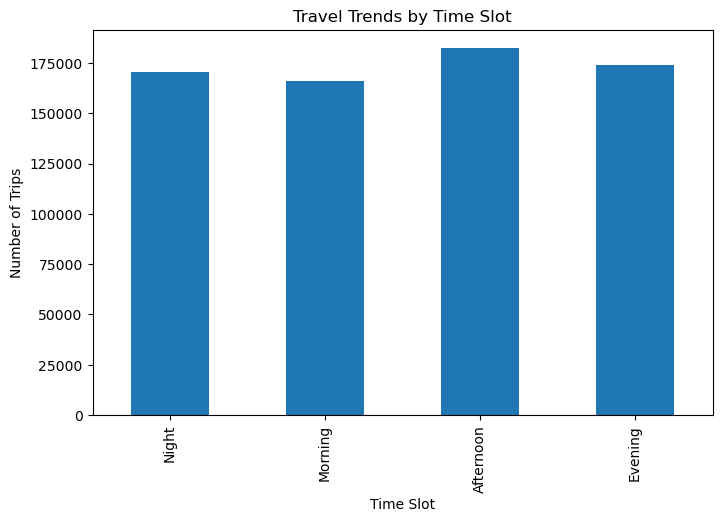

In [59]:
cab_rides_data_for_visualisation['time_slot'] = pd.cut(cab_rides_data_for_visualisation['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
time_slot_counts = cab_rides_data_for_visualisation['time_slot'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
time_slot_counts.plot(kind='bar', title='Travel Trends by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Number of Trips')
plt.show()



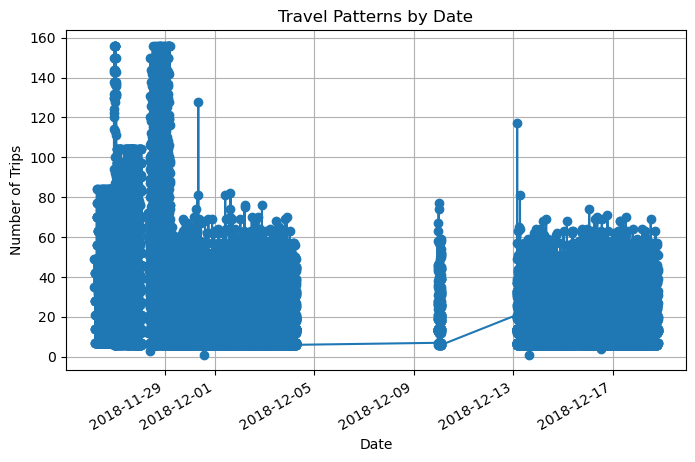

In [61]:
date_counts = cab_rides_data_for_visualisation['datetime'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
date_counts.plot(kind='line', marker='o', title='Travel Patterns by Date')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid()
plt.show()

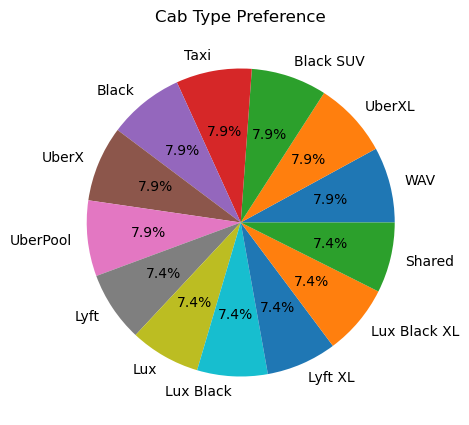

In [67]:
cab_type_counts = cab_rides_data_for_visualisation['cab_type'].value_counts()

plt.figure(figsize=(8, 5))
cab_type_counts.plot(kind='pie', autopct='%1.1f%%', title='Cab Type Preference')
plt.ylabel('')
plt.show()

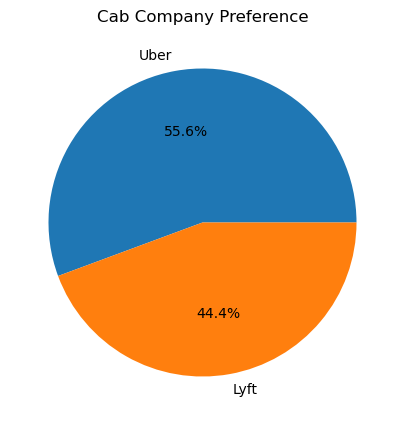

In [73]:
cab_company_counts = cab_rides_data_for_visualisation['cab_company'].value_counts()

plt.figure(figsize=(8, 5))
cab_company_counts.plot(kind='pie', autopct='%1.1f%%', title='Cab Company Preference')
plt.ylabel('')
plt.show()

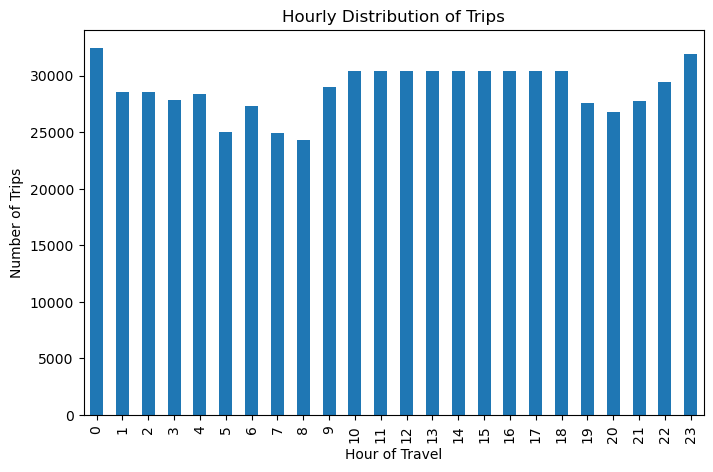

In [65]:
hourly_counts = cab_rides_data_for_visualisation['hour'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
hourly_counts.plot(kind='bar', title='Hourly Distribution of Trips')
plt.xlabel('Hour of Travel')
plt.ylabel('Number of Trips')
plt.show()



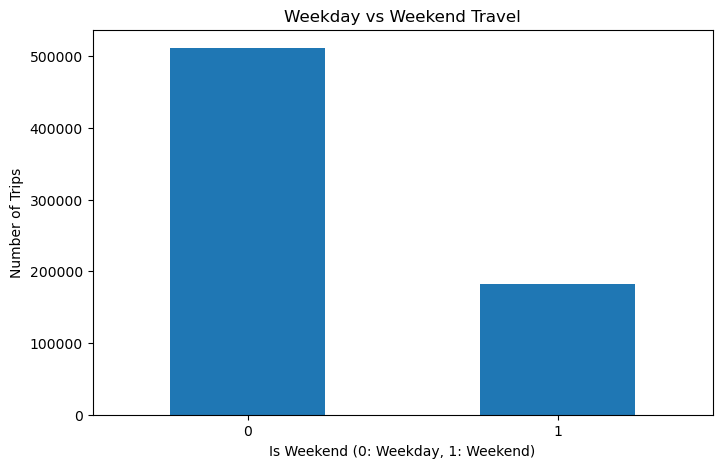

In [63]:
cab_rides_data_for_visualisation['weekday'] = pd.to_datetime(cab_rides_data_for_visualisation['date']).dt.dayofweek
cab_rides_data_for_visualisation['is_weekend'] = cab_rides_data_for_visualisation['weekday'].apply(lambda x: 1 if x >= 5 else 0)
weekday_counts = cab_rides_data_for_visualisation.groupby('is_weekend')['hour'].count()

plt.figure(figsize=(8, 5))
weekday_counts.plot(kind='bar', title='Weekday vs Weekend Travel')
plt.xlabel('Is Weekend (0: Weekday, 1: Weekend)')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

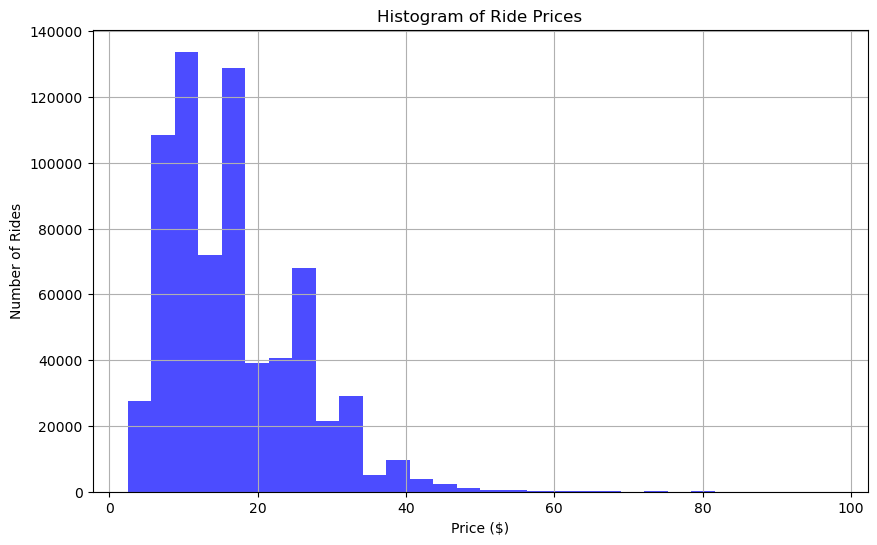

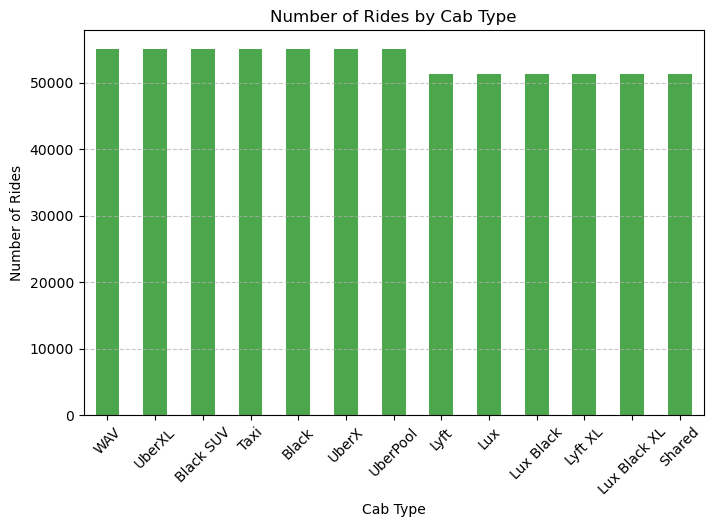

In [75]:


# Creating a histogram of ride prices
plt.figure(figsize=(10, 6))
plt.hist(cab_rides_data_for_visualisation['price'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Ride Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()





In [81]:
average_cost_by_hour = df_extended.groupby('hour')['price'].mean()

# 2. Identify peak and low-cost hours
peak_cost_hour = average_cost_by_hour.idxmax()
peak_cost_value = average_cost_by_hour.max()

low_cost_hour = average_cost_by_hour.idxmin()
low_cost_value = average_cost_by_hour.min()

# 3. Visualize average cost across hours
plt.figure(figsize=(10, 6))
average_cost_by_hour.plot(kind='line', marker='o', title='Average Cost by Hour of Travel')
plt.xlabel('Hour of Travel')
plt.ylabel('Average Cost ($)')
plt.grid()
plt.show()

NameError: name 'df_extended' is not defined

In [ ]:
# Creating a bar chart of cab types
cab_type_counts = cab_rides_data_for_visualisation['cab_type'].value_counts()

plt.figure(figsize=(8, 5))
cab_type_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Number of Rides by Cab Type')
plt.xlabel('Cab Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/z1/fbf3jw4x2k17yv3z5f3l04jm0000gn/T/ipykernel_22837/4023831780.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  price_heatmap_data = cab_rides_data_for_visualisation.pivot_table(
/var/folders/z1/fbf3jw4x2k17yv3z5f3l04jm0000gn/T/ipykernel_22837/4023831780.py:7: FutureWarning: The provided callable <function mean at 0x108160680> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_heatmap_data = cab_rides_data_for_visualisation.pivot_table(


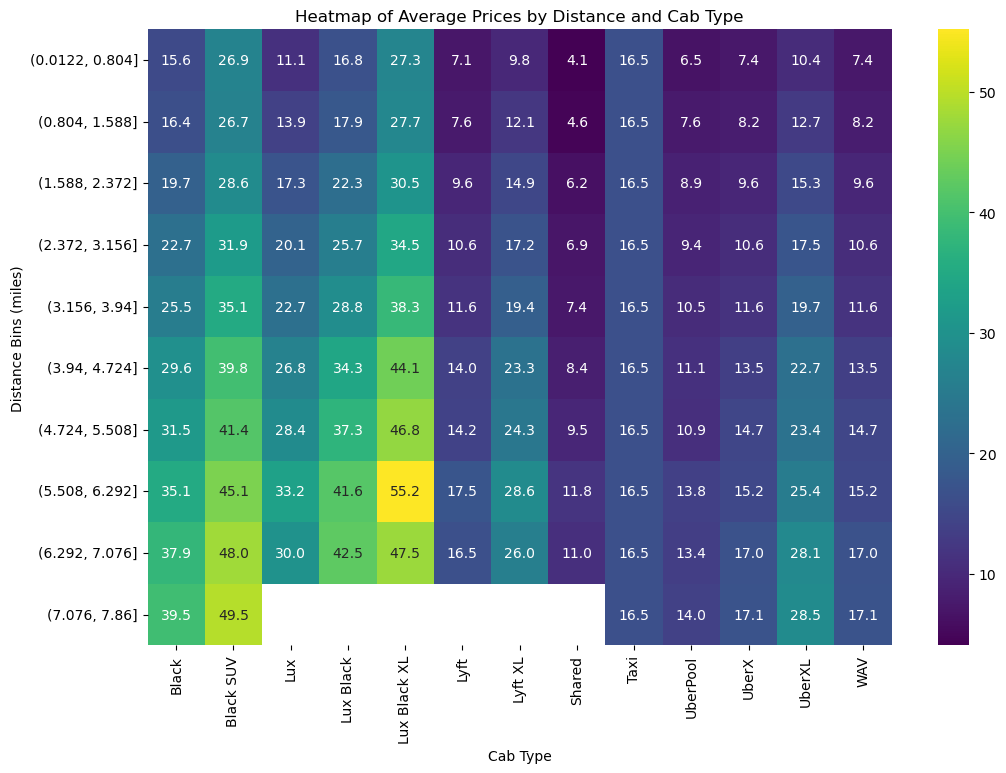

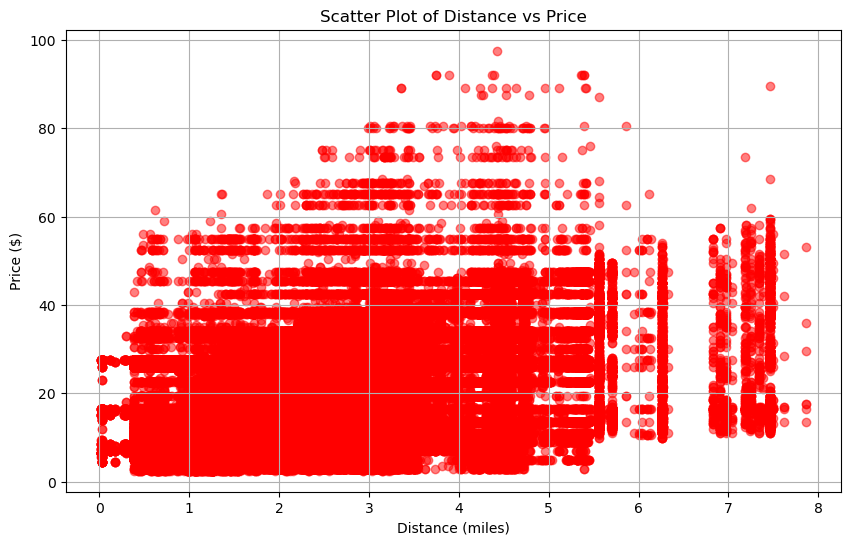

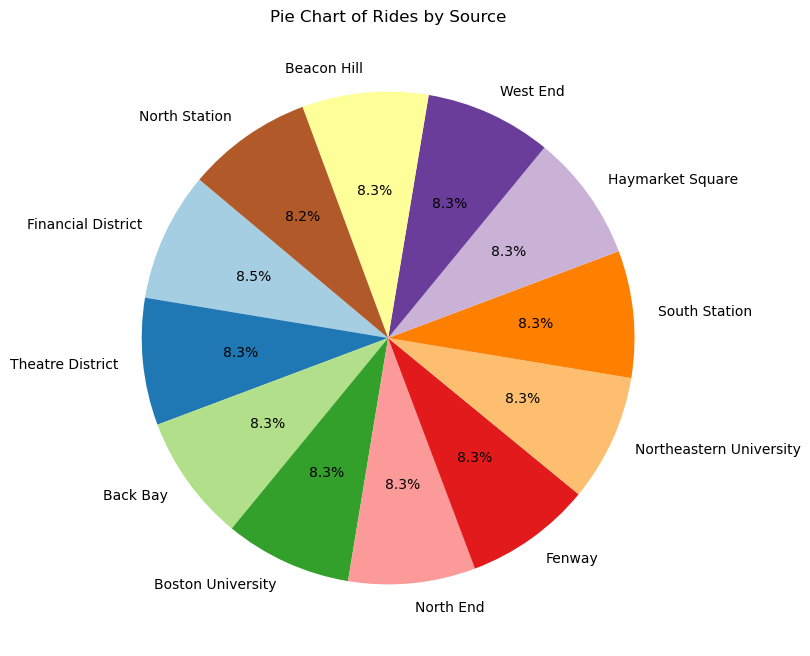

,total_rides,average_price,average_distance,average_surge
cab_type,,,,
Black,55095,20.523786,2.191399,1.000000
Black SUV,55096,30.286763,2.191378,1.000000
Lux,51235,17.771240,2.186968,1.037177
Lux Black,51235,23.062468,2.186968,1.037177
Lux Black XL,51235,32.324086,2.186968,1.037177
Lyft,51235,9.610885,2.186968,1.038045
Lyft XL,51235,15.309363,2.186968,1.038045
Shared,51233,6.029893,2.187012,1.000000
Taxi,55095,16.545125,2.191383,1.000000


In [79]:

import numpy as np

# Creating distance bins for better visualization
cab_rides_data_for_visualisation['distance_bins'] = pd.cut(cab_rides_data_for_visualisation['distance'], bins=10)

# Creating a pivot table to analyze prices across distances and cab types
price_heatmap_data = cab_rides_data_for_visualisation.pivot_table(
    values='price',
    index='distance_bins',
    columns='cab_type',
    aggfunc=np.mean
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
plt.title('Heatmap of Average Prices by Distance and Cab Type')
sns.heatmap(price_heatmap_data, annot=True, fmt=".1f", cmap='viridis')
plt.xlabel('Cab Type')
plt.ylabel('Distance Bins (miles)')
plt.show()
# Creating a scatter plot of distance vs price
plt.figure(figsize=(10, 6))
plt.scatter(cab_rides_data_for_visualisation['distance'], cab_rides_data_for_visualisation['price'], alpha=0.5, color='red')
plt.title('Scatter Plot of Distance vs Price')
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Creating a pie chart of rides by source
source_counts = cab_rides_data_for_visualisation['source'].value_counts()

plt.figure(figsize=(10, 8))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Pie Chart of Rides by Source')
plt.ylabel('')  # Removing the y-label as it's unnecessary for pie charts
plt.show()

# Grouping data by cab type to calculate the requested metrics
lyft_uber_analysis = cab_rides_data_for_visualisation.groupby('cab_type').agg(
    total_rides=('id', 'count'),
    average_price=('price', 'mean'),
    average_distance=('distance', 'mean'),
    average_surge=('surge_multiplier', 'mean')
)

lyft_uber_analysis

## Label Encoding

In [75]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [76]:
# Reimporting the necessary library and reinitializing the label_encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

# Create a list of columns to encode
golden_data = selected_features.copy()
cols_to_encode = [col for col in golden_data.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    golden_data[col] = label_encoder.fit_transform(golden_data[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

    # Print the mapping for the column
    print(f"Mapping for {col} column:")
    print(mapping,"\n")

Mapping for source column:
{np.int64(0): 'Back Bay', np.int64(1): 'Beacon Hill', np.int64(2): 'Boston University', np.int64(3): 'Fenway', np.int64(4): 'Financial District', np.int64(5): 'Haymarket Square', np.int64(6): 'North End', np.int64(7): 'North Station', np.int64(8): 'Northeastern University', np.int64(9): 'South Station', np.int64(10): 'Theatre District', np.int64(11): 'West End'} 

Mapping for destination column:
{np.int64(0): 'Back Bay', np.int64(1): 'Beacon Hill', np.int64(2): 'Boston University', np.int64(3): 'Fenway', np.int64(4): 'Financial District', np.int64(5): 'Haymarket Square', np.int64(6): 'North End', np.int64(7): 'North Station', np.int64(8): 'Northeastern University', np.int64(9): 'South Station', np.int64(10): 'Theatre District', np.int64(11): 'West End'} 

Mapping for cab_company column:
{np.int64(0): 'Lyft', np.int64(1): 'Uber'} 

Mapping for cab_type column:
{np.int64(0): 'Black', np.int64(1): 'Black SUV', np.int64(2): 'Lux', np.int64(3): 'Lux Black', np.int

## Creating Train and Test Data

In [77]:
target = 'price'

# Create feature matrix (X) and target vector (y)
X= golden_data.drop('price', axis=1)
y= golden_data['price']

# Convert categorical columns (e.g., is_rain, day_of_week) to numerical values
# X = pd.get_dummies(X, columns=['day_of_week', 'is_weekend'], drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (554456, 14)
X_test shape: (138615, 14)


## Linear Regression Model

In [78]:
# Linear Regression
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

#sumit

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_linear))
print("R-squared (R2):", r2_score(y_test, y_pred_linear))

Linear Regression Results:
Mean Squared Error (MSE): 39.81302544988929
R-squared (R2): 0.5008234522028521


## RF Model

In [79]:
# Train the Random Forest model
random_forest_model = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_rf))
print("R-squared (R2):", r2_score(y_test, y_pred_rf))

/var/folders/30/r6bdbml51pb1n3cswh9vqjv80000gn/T/ipykernel_95337/1984595022.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


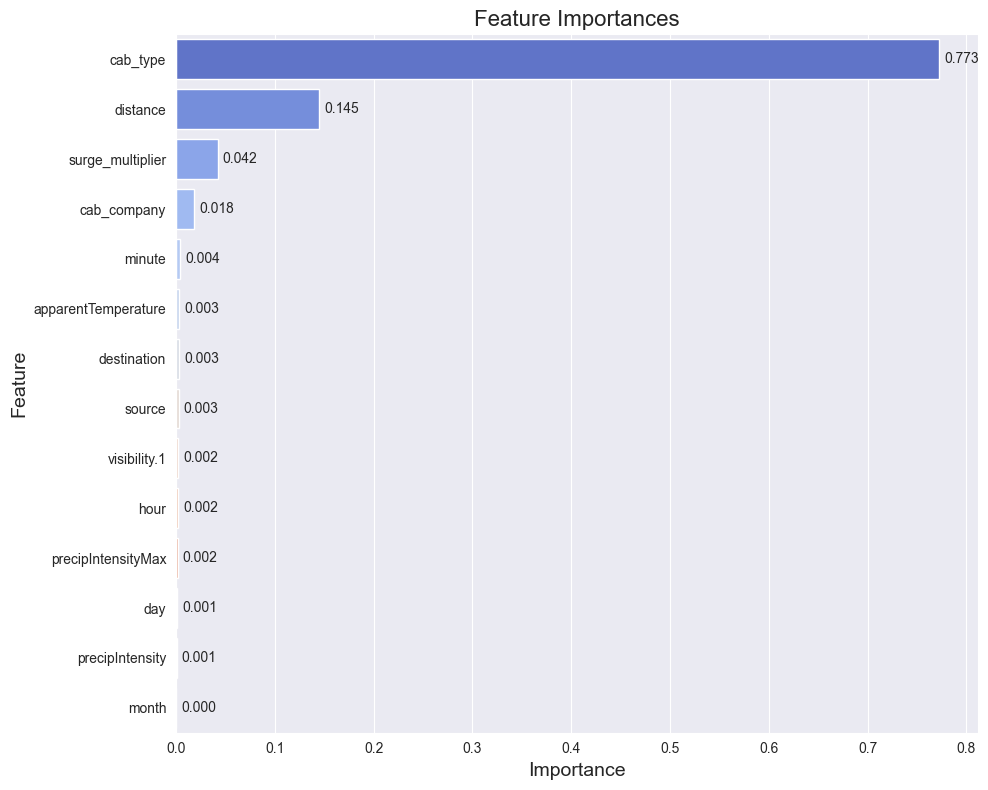

In [ ]:
# Get feature importances and sort them in descending order
importances = random_forest_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances['Importance'],
    y=feature_importances['Feature'],
    palette='coolwarm'  # Use a gradient color palette
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add annotations to each bar
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Decision Tree Regressor

In [ ]:

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_dt)
mse = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Optional: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Mean Absolute Error (MAE): 1.2697842104632349
Mean Squared Error (MSE): 5.245867219536928
R² Score: 0.9342578256557625

Feature Importances:
                Feature  Importance
3              cab_type    0.756865
4              distance    0.144471
5      surge_multiplier    0.041677
2           cab_company    0.025586
13               minute    0.007687
6   apparentTemperature    0.004942
12                 hour    0.003659
8          visibility.1    0.003611
1           destination    0.003237
0                source    0.002885
9    precipIntensityMax    0.002301
10                  day    0.001870
7       precipIntensity    0.000997
11                month    0.000210


Key Observations
Model Performance:

MAE:
1.21
1.21 indicates that, on average, predictions are off by $1.21.
MSE:
4.68
4.68, a relatively low value, suggests good accuracy for a regression model.
R²:
0.94
0.94 is excellent, indicating that 94% of the variance in price is explained by the features.
Feature Importance:

The most important features for predicting the price are:
cab_type:
78.03
%
78.03%
distance:
14.66
%
14.66%
surge_multiplier:
4.19
%
4.19%
Other features, such as cab_company (
0.7
%
0.7%) and apparentTemperature (
0.55
%
0.55%), contribute marginally.
Some features (e.g., is_rain, precipProbability, is_weekend) have negligible importance.
Feature Redundancy:

Features like is_rain, precipProbability, and others with near-zero importance might be unnecessary.

## Model Comparisons

Model Comparison:
Linear Regression - MSE: 39.64247098017616 | R2: 0.503193251077908
Random Forest Regressor - MSE: 2.6653362394333997 | R2: 0.9665975152618689
Decision Tree Regressor - MSE: 5.245867219536928 | R2: 0.9342578256557625


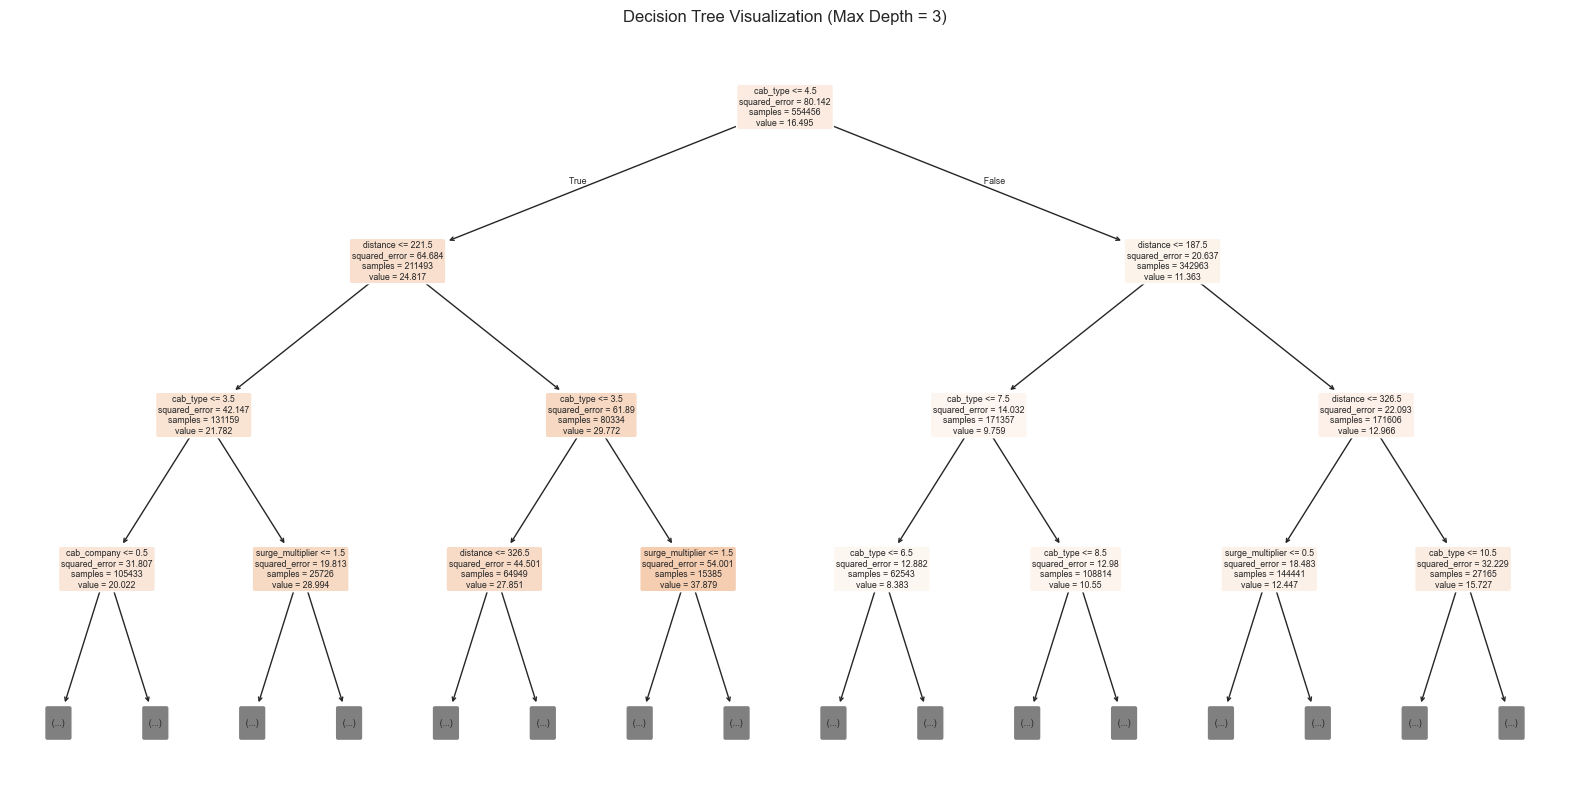


Decision Tree Rules:
|--- cab_type <= 4.50
|   |--- distance <= 221.50
|   |   |--- cab_type <= 3.50
|   |   |   |--- cab_company <= 0.50
|   |   |   |   |--- cab_type <= 2.50
|   |   |   |   |   |--- distance <= 120.50
|   |   |   |   |   |   |--- surge_multiplier <= 1.50
|   |   |   |   |   |   |   |--- distance <= 64.50
|   |   |   |   |   |   |   |   |--- surge_multiplier <= 0.50
|   |   |   |   |   |   |   |   |   |--- distance <= 40.50
|   |   |   |   |   |   |   |   |   |   |--- distance <= 39.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 32
|   |   |   |   |   |   |   |   |   |   |--- distance >  39.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |--- distance >  40.50
|   |   |   |   |   |   |   |   |   |   |--- distance <= 50.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 27
|   |   |   |   |   |   |   |   |   |   |--- distance >  50.50
|   |   

In [ ]:
# Compare the models
print("Model Comparison:")
print("Linear Regression - MSE:", mean_squared_error(y_test, y_pred_linear), "| R2:", r2_score(y_test, y_pred_linear))
print("Random Forest Regressor - MSE:", mean_squared_error(y_test, y_pred_rf), "| R2:", r2_score(y_test, y_pred_rf))
print("Decision Tree Regressor - MSE:", mean_squared_error(y_test, y_pred_dt), "| R2:", r2_score(y_test, y_pred_dt))
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Max Depth = 3)")
plt.show()

# Optional: Export textual representation of the tree
tree_rules = export_text(dt_model, feature_names=list(X_train.columns))
print("\nDecision Tree Rules:")
print(tree_rules)

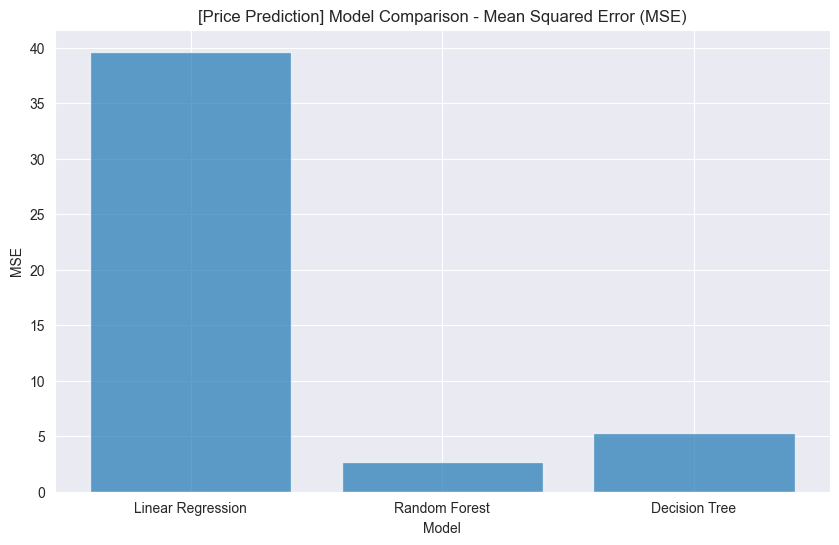

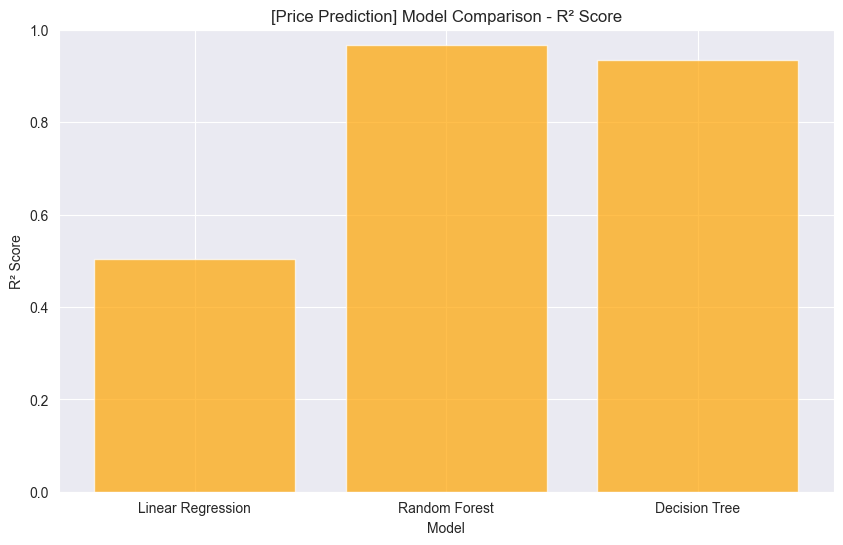

In [ ]:
# Import necessary libraries for evaluation and metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the models
models = ['Linear Regression', 'Random Forest', 'Decision Tree']

# Calculate MSE and R² values
mse_values = [
    mean_squared_error(y_test, y_pred_linear),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_dt)
]
r2_values = [
    r2_score(y_test, y_pred_linear),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_dt)
]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, alpha=0.7, label='MSE')
plt.title('[Price Prediction] Model Comparison - Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(models)
plt.show()

# Plot the R² values
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, alpha=0.7, color='orange', label='R² Score')
plt.title('[Price Prediction] Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.xticks(models)
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.show()

## Splitting dataset into different cab company types

In [ ]:
# split selected features into differernt cab company types

uber_data_df = selected_features[selected_features['cab_company'] == 'Uber'].copy(deep=True)
lyft_data_df = selected_features[selected_features['cab_company'] == 'Lyft'].copy(deep=True)
uber_data_df.drop(['cab_company'], axis=1, inplace=True)
lyft_data_df.drop(['cab_company'], axis=1, inplace=True)



## Uber

In [ ]:
# Reimporting the necessary library and reinitializing the label_encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
# Create a list of columns to encode
cols_to_encode = [col for col in uber_data_df.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    uber_data_df[col] = label_encoder.fit_transform(uber_data_df[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

    # Print the mapping for the column
    # print(f"Mapping for {col} column:")
    # print(mapping,"\n")
uber_data_df

,source,destination,cab_type,price,distance,surge_multiplier,apparentTemperature,precipIntensity,visibility.1,precipIntensityMax,day,month,hour,minute
66422,7,5,4,7.000000,19,0,248,0,6,55,12,0,3,40
446073,10,6,2,15.795343,108,0,248,0,6,55,12,0,3,40
32121,7,3,6,10.500000,255,0,248,0,6,55,12,0,3,40
613927,10,3,4,19.500000,222,0,248,0,6,55,12,0,3,40
613926,10,3,5,32.000000,222,0,248,0,6,55,12,0,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204548,10,3,2,15.795343,217,0,23,0,167,7,11,1,19,15
34918,4,5,4,7.000000,76,0,23,0,167,7,11,1,19,15
215397,3,10,1,33.500000,217,0,23,0,167,7,11,1,19,15
166550,5,0,4,11.500000,181,0,23,0,167,7,11,1,19,15


In [ ]:
target = 'price'
# Create feature matrix (X) and target vector (y)
X_uber = uber_data_df.drop('price', axis=1)
y_uber = uber_data_df['price']

# Convert categorical columns (e.g., is_rain, day_of_week) to numerical values
# X = pd.get_dummies(X, columns=['day_of_week', 'is_weekend'], drop_first=True)

# Split the dataset into training and testing sets
X_train_uber, X_test_uber, y_train_uber, y_test_uber = train_test_split(X_uber, y_uber, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train_uber.shape)
print("X_test shape:", X_test_uber.shape)

X_train shape: (308530, 13)
X_test shape: (77133, 13)


### Linear Regression Model for Uber

In [ ]:
# Linear Regression for Uber
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_uber, y_train_uber)

# Predict on the test set
y_pred_linear_uber = linear_model.predict(X_test_uber)

#sumit

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_linear_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_linear_uber))

Linear Regression Results:
Mean Squared Error (MSE): 33.604619892878475
R-squared (R2): 0.46501543110391397


### Radom Forest Model for Uber

In [ ]:
# Train the Random Forest model
random_forest_model_uber = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model_uber.fit(X_train_uber, y_train_uber)

# Predict on the test set
y_pred_rf_uber = random_forest_model_uber.predict(X_test_uber)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_rf_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_rf_uber))

Random Forest Regressor Results:
Mean Squared Error (MSE): 3.305445298404232
R-squared (R2): 0.9473774072251555


Random Forest Regressor Results:
Mean Squared Error (MSE): 3.305445298404232
R-squared (R2): 0.9473774072251555


/var/folders/30/r6bdbml51pb1n3cswh9vqjv80000gn/T/ipykernel_95337/3506728881.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


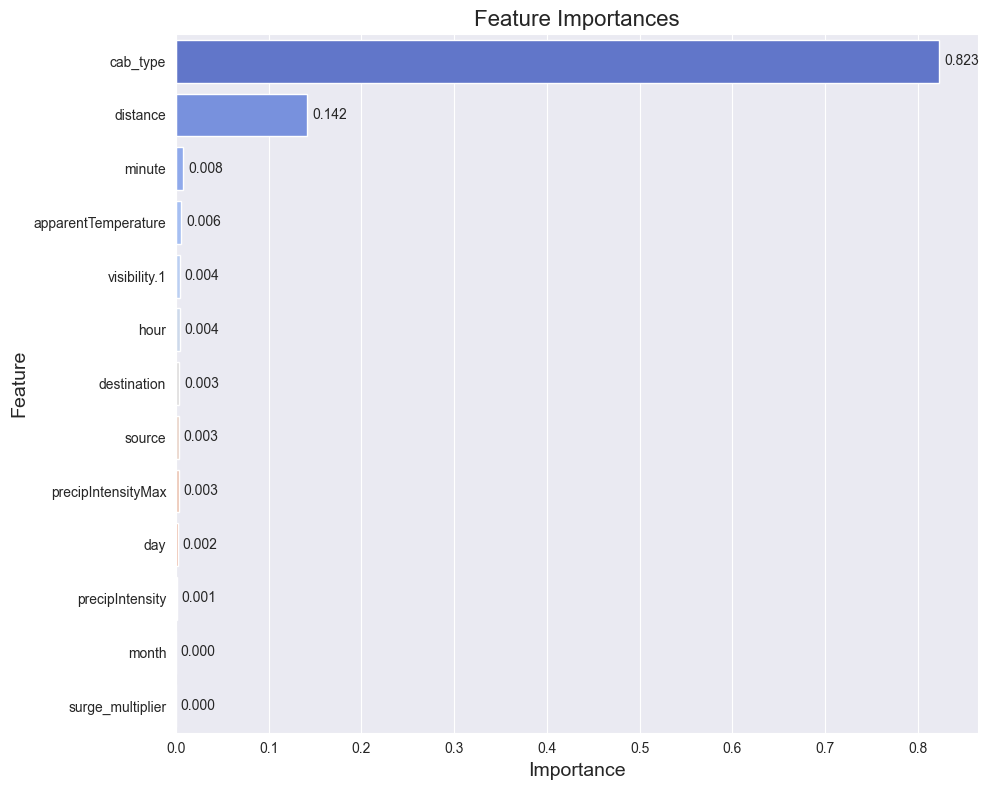

In [ ]:
# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_rf_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_rf_uber))
# Get feature importances and sort them in descending order
importances_uber = random_forest_model_uber.feature_importances_
feature_names_uber = X_uber.columns
feature_importances_uber = pd.DataFrame({'Feature': feature_names_uber, 'Importance': importances_uber})
feature_importances_uber = feature_importances_uber.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances_uber['Importance'],
    y=feature_importances_uber['Feature'],
    palette='coolwarm'  # Use a gradient color palette
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add annotations to each bar
for i, v in enumerate(feature_importances_uber['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Decision Tree Regressor for Uber

In [ ]:

dt_model_uber = DecisionTreeRegressor(random_state=42)
dt_model_uber.fit(X_train_uber, y_train_uber)
y_pred_dt_uber = dt_model_uber.predict(X_test_uber)

mae = mean_absolute_error(y_test_uber, y_pred_dt_uber)
mse = mean_squared_error(y_test_uber, y_pred_dt_uber)
r2 = r2_score(y_test_uber, y_pred_dt_uber)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Optional: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train_uber.columns,
    'Importance': dt_model_uber.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Mean Absolute Error (MAE): 1.4097970388812964
Mean Squared Error (MSE): 6.536357992579916
R² Score: 0.8959413713365075

Feature Importances:
                Feature  Importance
2              cab_type    0.812529
3              distance    0.139978
12               minute    0.012804
5   apparentTemperature    0.007844
11                 hour    0.005865
7          visibility.1    0.005208
1           destination    0.003699
0                source    0.003654
8    precipIntensityMax    0.003478
9                   day    0.002995
6       precipIntensity    0.001566
10                month    0.000380
4      surge_multiplier    0.000000


## Lyft

In [ ]:
# Reimporting the necessary library and reinitializing the label_encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

# Create a list of columns to encode
cols_to_encode = [col for col in lyft_data_df.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    lyft_data_df[col] = label_encoder.fit_transform(lyft_data_df[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

    # Print the mapping for the column
    # print(f"Mapping for {col} column:")
    # print(mapping,"\n")
lyft_data_df

,source,destination,cab_type,price,distance,surge_multiplier,apparentTemperature,precipIntensity,visibility.1,precipIntensityMax,day,month,hour,minute
184332,6,11,3,7.0,84,0,248,0,6,55,12,0,3,40
167114,2,1,0,19.5,227,0,248,0,6,55,12,0,3,40
184333,6,11,5,5.0,84,0,248,0,6,55,12,0,3,40
184334,6,11,0,13.5,84,0,248,0,6,55,12,0,3,40
184335,6,11,1,19.5,84,0,248,0,6,55,12,0,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205379,8,1,0,16.5,201,0,23,0,167,7,11,1,19,15
290784,8,1,5,9.0,261,0,23,0,167,7,11,1,19,15
290783,8,1,4,16.5,261,0,23,0,167,7,11,1,19,15
290782,8,1,3,11.0,261,0,23,0,167,7,11,1,19,15


In [ ]:
target = 'price'
# Create feature matrix (X) and target vector (y)
X_lyft = lyft_data_df.drop('price', axis=1)
y_lyft = lyft_data_df['price']

# Convert categorical columns (e.g., is_rain, day_of_week) to numerical values
# X = pd.get_dummies(X, columns=['day_of_week', 'is_weekend'], drop_first=True)

# Split the dataset into training and testing sets
X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train_lyft.shape)
print("X_test shape:", X_test_lyft.shape)

X_train shape: (245926, 13)
X_test shape: (61482, 13)


## Linear Regression for Lyft

In [ ]:
# Linear Regression for Uber
# Train the Linear Regression model
linear_model_lyft = LinearRegression()
linear_model_lyft.fit(X_train_lyft, y_train_lyft)

# Predict on the test set
y_pred_linear_lyft = linear_model_lyft.predict(X_test_lyft)

#sumit

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_lyft, y_pred_linear_lyft))
print("R-squared (R2):", r2_score(y_test_lyft, y_pred_linear_lyft))

Linear Regression Results:
Mean Squared Error (MSE): 54.106045904704565
R-squared (R2): 0.4606320361760139


## Random forest for Lyft

In [ ]:
# Train the Random Forest model
random_forest_model_lyft = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model_lyft.fit(X_train_lyft, y_train_lyft)

# Predict on the test set
y_pred_rf_lyft = random_forest_model_lyft.predict(X_test_lyft)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_lyft, y_pred_rf_lyft))
print("R-squared (R2):", r2_score(y_test_lyft, y_pred_rf_lyft))

Random Forest Regressor Results:
Mean Squared Error (MSE): 1.921273379316906
R-squared (R2): 0.9808473657014866


Random Forest Regressor Results:
Mean Squared Error (MSE): 1.921273379316906
R-squared (R2): 0.9808473657014866


/var/folders/30/r6bdbml51pb1n3cswh9vqjv80000gn/T/ipykernel_95337/1200634200.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


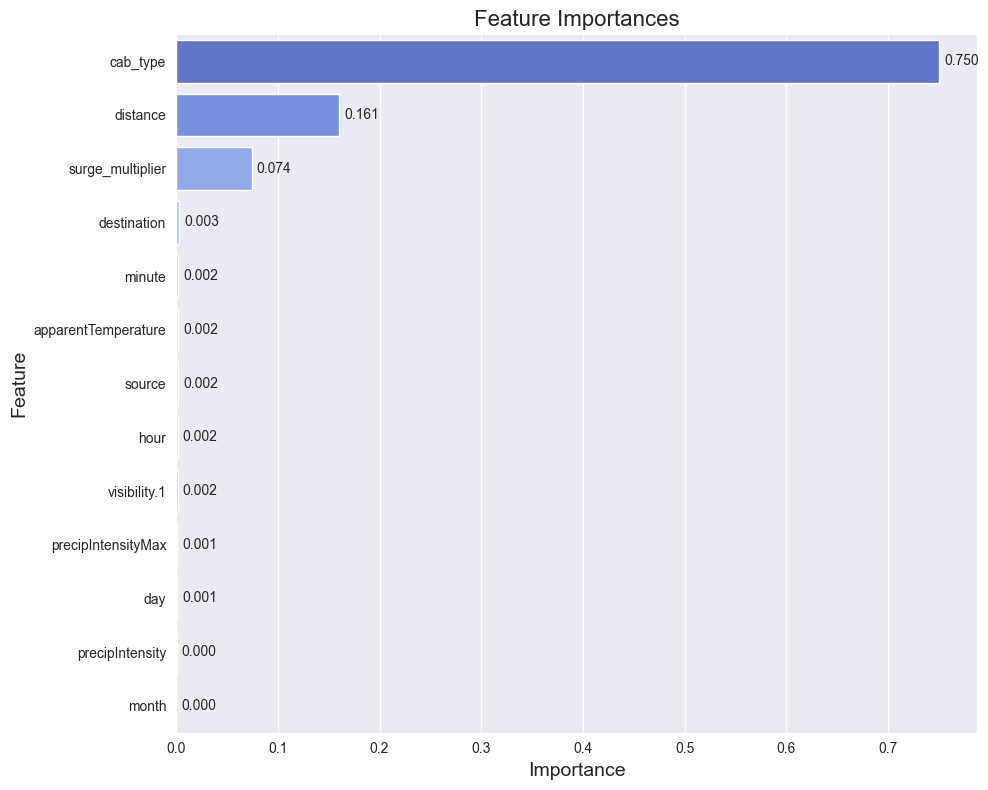

In [ ]:
# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_lyft, y_pred_rf_lyft))
print("R-squared (R2):", r2_score(y_test_lyft, y_pred_rf_lyft))
# Get feature importances and sort them in descending order
importances_lyft = random_forest_model_lyft.feature_importances_
feature_names_lyft = X_lyft.columns
feature_importances_lyft = pd.DataFrame({'Feature': feature_names_lyft, 'Importance': importances_lyft})
feature_importances_lyft = feature_importances_lyft.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances_lyft['Importance'],
    y=feature_importances_lyft['Feature'],
    palette='coolwarm'  # Use a gradient color palette
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add annotations to each bar
for i, v in enumerate(feature_importances_lyft['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Decision Regressor for Lyft

In [ ]:

dt_model_lyft = DecisionTreeRegressor(random_state=42)
dt_model_lyft.fit(X_train_lyft, y_train_lyft)
y_pred_dt_lyft = dt_model_lyft.predict(X_test_lyft)

mae = mean_absolute_error(y_test_lyft, y_pred_dt_lyft)
mse = mean_squared_error(y_test_lyft, y_pred_dt_lyft)
r2 = r2_score(y_test_lyft, y_pred_dt_lyft)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Optional: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train_lyft.columns,
    'Importance': dt_model_lyft.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Mean Absolute Error (MAE): 1.0933652125825444
Mean Squared Error (MSE): 3.6335568018101054
R² Score: 0.963778093540916

Feature Importances:
                Feature  Importance
2              cab_type    0.746423
3              distance    0.160794
4      surge_multiplier    0.073585
12               minute    0.003466
5   apparentTemperature    0.002969
1           destination    0.002909
0                source    0.002287
11                 hour    0.002174
7          visibility.1    0.002118
8    precipIntensityMax    0.001402
9                   day    0.001229
6       precipIntensity    0.000530
10                month    0.000115


In [ ]:
import numpy as np

# Simulated random forest model for demonstration
class RandomForestModel:
    def predict(self, X):
        return [42.0]  # Dummy prediction value for testing

# Instantiate the model
#random_forest_model = RandomForestModel()

# Define the prediction function
def predict_cab_price(source, destination, cab_company, cab_type, price, distance,
                      surge_multiplier, apparentTemperature, precipIntensity,
                      visibility, precipIntensityMax, day, month, hour, minute):
    # Map inputs to an array based on feature order
    x = np.zeros(len(columns_to_include))
    x[0] = source
    x[1] = destination
    x[2] = cab_company
    x[3] = cab_type
    x[4] = price
    x[5] = distance
    x[6] = surge_multiplier
    x[7] = apparentTemperature
    x[8] = precipIntensity
    x[9] = visibility
    x[10] = precipIntensityMax
    x[11] = day
    x[12] = month
    x[13] = hour
    x[14] = minute

    # Return the predicted price
    return random_forest_model.predict([x])[0]

# Feature list
columns_to_include = [
    'source', 'destination', 'cab_company', 'cab_type', 'price', 'distance',
    'surge_multiplier', 'apparentTemperature', 'precipIntensity',
    'visibility.1', 'precipIntensityMax', 'day', 'month', 'hour', 'minute',
]

# Example of calling the prediction function
source = 8
destination = 5
cab_company = 0  # Example: 0 for 'Uber', 1 for 'Lyft'
cab_type = 1  # Example: 1 for 'UberX', 2 for 'UberXL'
price = 15.5
distance = 10.2
surge_multiplier = 1.5
apparentTemperature = 22.5
precipIntensity = 0.02
visibility = 9.5
precipIntensityMax = 0.05
day = 12
month = 5
hour = 14
minute = 30

predicted_price = predict_cab_price(
    source, destination, cab_company, cab_type, price, distance,
    surge_multiplier, apparentTemperature, precipIntensity,
    visibility, precipIntensityMax, day, month, hour, minute
)

print(f"Predicted Cab Price: ${predicted_price:.2f}")





/Users/amolbohora/NEU/CS6620/CS66220-Project/.venv/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 15 features, but RandomForestRegressor is expecting 14 features as input.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d6a3a5f6-4e73-4ad8-9317-f137a92b5fa0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>